<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Pre_%26_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

Riferimento: https://stackoverflow.com/questions/30483246/how-to-check-if-a-python-module-has-been-imported

In [5]:
catboost = 'catboost'
if catboost not in sys.modules:
  !pip install catboost

# Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [6]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


# Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [8]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data = mf.feature_scaling(data)
data, categorical_names = mf.encoding(data, 'cat_sign_col')
# ratio_transaction = mf.ratio(data)

### Load

In [11]:
load = False
if load:
  model = CatBoostClassifier()
  model.load_model('catboost')  
  # model.load_model('catboost_class_weights')

### Train validation test split


In [13]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [64]:
save_id = True 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Categorical Boost

Con 2000 iterazioni: AUC= 0.9, AP= 0.7

Con 4000 iterazioni: AUC= 0.92, AP= 0.73

Con class_weight: AUC = 0.91, AP = 0.68, F1 = 0.81, CM =  [[112057   1796]
 [  1459   2795]]

Non è stato fatto nè il one hot encoding nè l'easy ensemble.

Documentazione CatBoost: https://catboost.ai/docs/concepts/python-quickstart.html

Categorical features parameter: https://github.com/catboost/catboost/issues/934

gpu: https://catboost.ai/docs/features/training-on-gpu.html

Riferimento salvataggio del modello: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python

Riferimento class_weights: https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance

In [ ]:
cat_feature_list = np.arange(176,206)
train_list = mf.to_list(X_train, cat_feature_list)

In [57]:
from catboost import CatBoostClassifier#, Pool
model = CatBoostClassifier(iterations=3000, boosting_type='Plain', bootstrap_type='Bernoulli', 
                            subsample=0.5, border_count=32,
                            depth=10, learning_rate=1, task_type="GPU",
                            cat_features = cat_feature_list,# categorical_features, 
                            loss_function='CrossEntropy', verbose=False)
model.fit(train_list, y_train)

In [58]:
save = True
if save:
  model.save_model('catboost_new')

# Performance evaluation

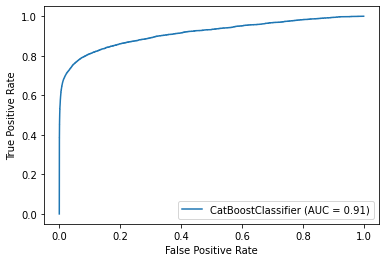

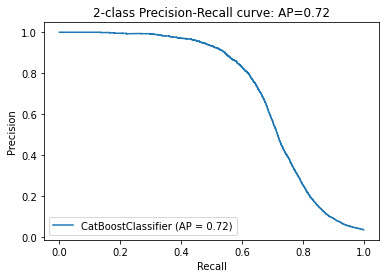

In [59]:
mf.performance(model, X_val, y_val)

[[113367    486]
 [  1726   2528]]


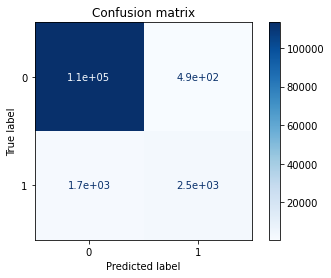

In [60]:
mf.conf_matrix(model, X_val, y_val)

In [61]:
mf.f1(model, X_val, y_val)

0.8429952534848734